<a href="https://colab.research.google.com/github/pcgames/Python-new/blob/master/task_raiffizen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install catboost

     |████████████████████████████████| 60.6MB 1.3MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import preprocessing
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

import lightgbm
# import catboost
from sklearn.base import TransformerMixin
from collections import Counter

In [0]:
from sklearn.metrics import make_scorer, roc_auc_score
roc_auc_scorer = make_scorer(roc_auc_score)


In [0]:
%matplotlib inline

In [0]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Colab Notebooks/raif

/content/drive/My Drive/Colab Notebooks/raif


In [0]:
task=pd.read_excel("./task.xlsx")

посмотрим на количество нанов в нашем датасете

In [0]:
task1=task.copy()
print(task1.isna().sum())
print(task.isna().sum())

customer_month_salary      41
sum_credit_current          0
term_credit_current         0
form                       22
sphere                     19
type                       26
EDUCATION                  17
age                         0
marital_status              0
time_at_work               17
GENDER                      0
month_passport_issued       0
month_with_bank          1039
CITY                        4
target                      0
ID                          0
dtype: int64
customer_month_salary      41
sum_credit_current          0
term_credit_current         0
form                       22
sphere                     19
type                       26
EDUCATION                  17
age                         0
marital_status              0
time_at_work               17
GENDER                      0
month_passport_issued       0
month_with_bank          1039
CITY                        4
target                      0
ID                          0
dtype: int64


как видно их достаточно много, при этом датасет не особо большой, поэтому их надо хорошо обработать

как правило, люди когда приходят на новое место работы начинают сотрудничать с банками с которыми работает организация, поэтому давайте посмотрим на корелляцию в банке и на работе

In [0]:
# индексы с нанами для количества времени в банке
ind_with_nan=[i for i in task.month_with_bank.index if np.isnan(task.month_with_bank.iloc[i])]

In [0]:
#индексы пользователей без нанов
ind_not_nan=[i for i in task.month_with_bank.index if np.isnan(task.month_with_bank.iloc[i])==False and np.isnan(task.time_at_work.iloc[i])==False]

In [0]:
#посмотрим на корелляцию данных столбцов
print(np.dot(task.month_with_bank.iloc[ind_not_nan],task.time_at_work.iloc[ind_not_nan])/(
np.linalg.norm(task.month_with_bank.iloc[ind_not_nan])*
np.linalg.norm(task.time_at_work.iloc[ind_not_nan]))
)

0.6563911311892086


можно сделать вывод что корелляция между ними есть

заменим значения на во времени с банком на время на работе

In [0]:
task1.month_with_bank.iloc[ind_with_nan]=task1.time_at_work.iloc[ind_with_nan]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


возьмем среднюю зарплату для каждого возраста, для заполнения нанов

In [0]:
age_groups = task1.groupby("age")
age_sals = age_groups['customer_month_salary'].mean()
a = []
for i in task1.age.values:
  a.append(age_sals[i])

task1['mean_age_salary'] = a
task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

In [0]:
data=task1.copy()

In [0]:
# найдем индексы с нанами для времени на работе, чтобы заменить их на время в банке
ind_with_nan_time=[i for i in task.time_at_work.index if np.isnan(task.time_at_work.iloc[i])]

In [0]:
task1.time_at_work.iloc[ind_with_nan_time]=task1.month_with_bank.iloc[ind_with_nan_time]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


посмотрим сколько нанов у нас осталось

In [0]:
print(task1.isna().sum())
print(data.isna().sum())

customer_month_salary       0
sum_credit_current          0
term_credit_current         0
form                       22
sphere                     19
type                       26
EDUCATION                  17
age                         0
marital_status              0
time_at_work               14
GENDER                      0
month_passport_issued       0
month_with_bank          1039
CITY                        4
target                      0
ID                          0
mean_age_salary             0
dtype: int64
customer_month_salary       0
sum_credit_current          0
term_credit_current         0
form                       22
sphere                     19
type                       26
EDUCATION                  17
age                         0
marital_status              0
time_at_work               17
GENDER                      0
month_passport_issued       0
month_with_bank          1039
CITY                        4
target                      0
ID                         

In [0]:
print(task1.isna().sum())
print(task.isna().sum())

customer_month_salary       0
sum_credit_current          0
term_credit_current         0
form                       22
sphere                     19
type                       26
EDUCATION                  17
age                         0
marital_status              0
time_at_work               14
GENDER                      0
month_passport_issued       0
month_with_bank          1039
CITY                        4
target                      0
ID                          0
mean_age_salary             0
dtype: int64
customer_month_salary      41
sum_credit_current          0
term_credit_current         0
form                       22
sphere                     19
type                       26
EDUCATION                  17
age                         0
marital_status              0
time_at_work               17
GENDER                      0
month_passport_issued       0
month_with_bank          1039
CITY                        4
target                      0
ID                         

к сожалению остались наны только тех объектов у которых их нельзя заменить, поэтому попробуем заменить эти данные на средние значения по признакам, после чего дропнем объекты с нанами

In [0]:
# task1.iloc[:,0]=task1.iloc[:,0].fillna(task1.iloc[1:,0].mean())
task1.iloc[:,9]=task1.iloc[:,9].fillna(task1.iloc[:,9].mean())
task1.iloc[:,12]=task1.iloc[:,12].fillna(task1.iloc[:,12].mean())
# task1.iloc[:,12]=task1.iloc[:,12].fillna(0)


In [0]:
task1=task1.dropna()

In [0]:
# task1.iloc[:,0]=task1.iloc[:,0].fillna(task1.iloc[1:,0].mean())
data.iloc[:,9]=data.iloc[:,9].fillna(data.iloc[:,9].mean())
data.iloc[:,12]=data.iloc[:,12].fillna(data.iloc[:,12].mean())
# task1.iloc[:,12]=task1.iloc[:,12].fillna(0)
data=data.dropna()

# Посмотрим на выбрасы

In [0]:
task1.describe()

,customer_month_salary,sum_credit_current,term_credit_current,age,time_at_work,month_passport_issued,month_with_bank,target,ID,mean_age_salary
count,4.740000e+03,4.740000e+03,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000
mean,5.801442e+04,3.404854e+05,48.724473,36.971308,61.006329,92.243249,43.921498,0.326793,2394.065190,57767.709638
std,6.291574e+04,3.005545e+05,16.145638,9.368205,64.466391,48.799188,30.202152,0.469090,1376.311554,11929.348771
min,0.000000e+00,3.000000e+04,12.000000,22.000000,1.000000,0.000000,-1.000000,0.000000,1.000000,0.000000
25%,2.843469e+04,1.510000e+05,36.000000,29.000000,15.000000,52.000000,22.000000,0.000000,1204.750000,51585.351826
50%,4.192288e+04,2.750000e+05,60.000000,35.000000,39.000000,93.000000,43.957663,0.000000,2397.500000,58206.622949
75%,6.500000e+04,4.400000e+05,60.000000,44.000000,82.000000,134.000000,53.000000,1.000000,3586.250000,67807.651145
max,1.357620e+06,8.000000e+06,84.000000,64.000000,478.000000,230.000000,200.000000,1.000000,4771.000000,121155.217500


In [0]:
def outlier_info(data,feature,cutoff=None):
  """   Выводит информацию о выбросах для заданного признака.   
        feature - признак, по которому мы хотим получить информацию о выбросах   
        cutoff - значение признака, которое считаем крайним не выбросом            
        (если значение признака больше cutoff, то считаем его выбросом)   return: None   """

  plt.figure(figsize=(10,6))
  plt.scatter(data[data['target']==1].index,data[data['target']==1][feature],color='darkgreen',label='вернули кредит',alpha=0.7)
  plt.scatter(data[data['target']==0].index,data[data['target']==0][feature],color='red',label='не вернули кредит',alpha=0.7)
  plt.xlabel('Номер объекта')
  plt.ylabel('Значение признака {}'.format(feature))
  plt.title('Зависимость {} от объекта'.format(feature))
  if (cutoff!=None):
    plt.hlines(cutoff,data.index.min(),data.index.max(),linewidth=3,color='yellow',label='cutoff')
    ratio=data[data[feature]>cutoff].shape[0]/data.shape[0]
    print('Доля объектов со значением признака {} больше, чем {}, равна {}'.format(feature,cutoff,ratio))
    print('Таких объектов: {} из {}'.format(data[data[feature]>cutoff].shape[0],data.shape[0]))
  plt.legend(fontsize=14)
  plt.show()


Доля объектов со значением признака customer_month_salary больше, чем 650000, равна 0.0014767932489451476
Таких объектов: 7 из 4740


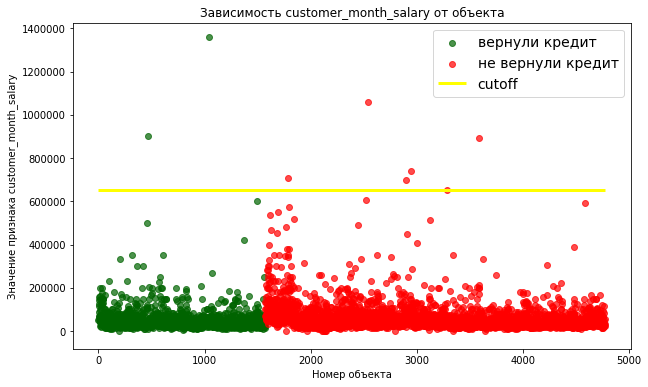

In [0]:
outlier_info(task1,'customer_month_salary',650000)

Доля объектов со значением признака sum_credit_current больше, чем 3000000, равна 0.0002109704641350211
Таких объектов: 1 из 4740


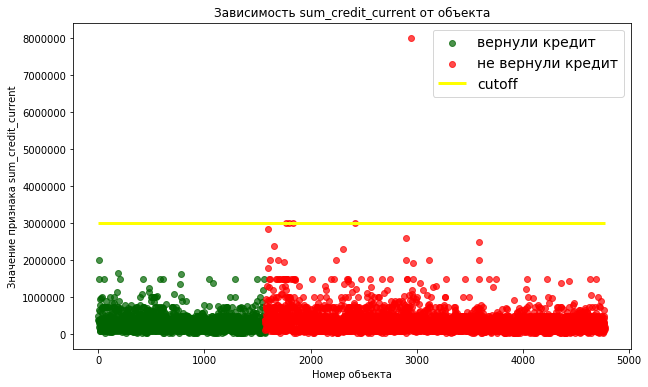

In [0]:
outlier_info(task1,'sum_credit_current',3000000)

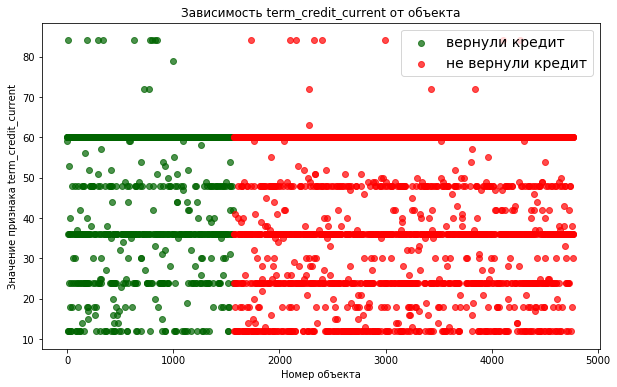

In [0]:
outlier_info(task1,'term_credit_current')

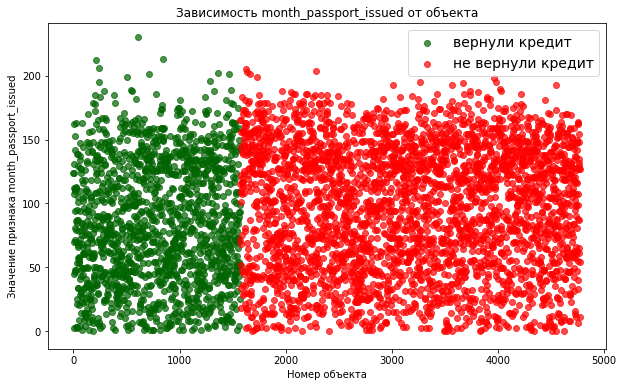

In [0]:
outlier_info(task1,'month_passport_issued')

Доля объектов со значением признака month_with_bank больше, чем 45, равна 0.309915611814346
Таких объектов: 1469 из 4740


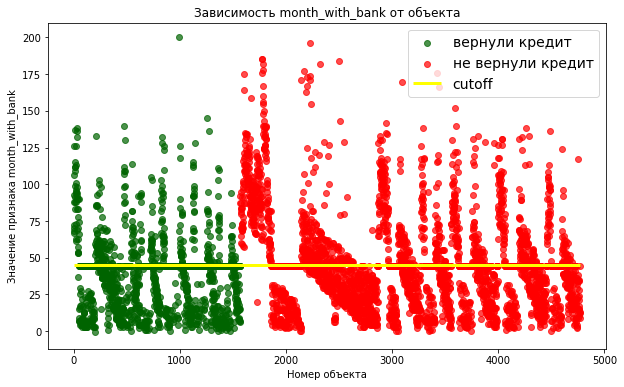

In [0]:
outlier_info(task1,'month_with_bank',45)

Доля объектов со значением признака time_at_work больше, чем 1, равна 0.9985232067510549
Таких объектов: 4733 из 4740


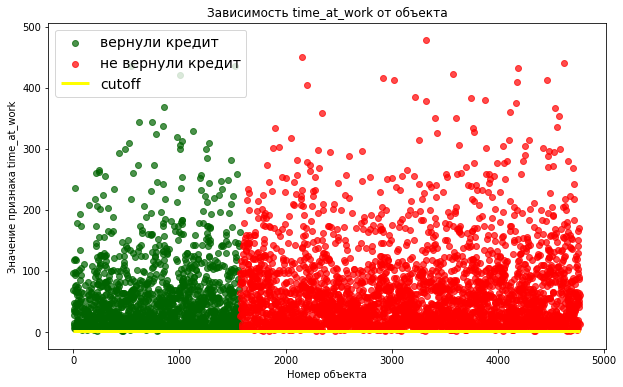

In [0]:
outlier_info(task1,'time_at_work',1)

можно заметить что среди всех представленных данных существуют оюъекты у которых время работы время в банке и время молучения паспорта меньше месяца,есть предположение что это одни и те же объекты, давайте посмотрим на них

In [0]:
task1[(task1['time_at_work']<1)&
     (task1['month_with_bank']<1)&
     (task1['month_passport_issued']<1)&
     (task1['customer_month_salary']<120)]

,customer_month_salary,sum_credit_current,term_credit_current,form,sphere,type,EDUCATION,age,marital_status,time_at_work,GENDER,month_passport_issued,month_with_bank,CITY,target,ID,mean_age_salary


In [0]:
task1[task1.time_at_work==46].shape

(49, 17)

как результат предположение не верно

давайте посмотрим на самых высокозарабатывающих объектов

In [0]:
task1[(task1['customer_month_salary']>10e+5)]

,customer_month_salary,sum_credit_current,term_credit_current,form,sphere,type,EDUCATION,age,marital_status,time_at_work,GENDER,month_passport_issued,month_with_bank,CITY,target,ID,mean_age_salary
1038,1357620.00,1500000,51,ООО,Торговля,менеджер среднего звена,высшее,56,разведен / разведена,17.0,мужской,125,32.0,Омск,1,1039,91697.540909
2535,1057999.17,1000000,60,ООО,"Производство, добывающая промышленность",менеджер высшего звена,высшее,39,женат / замужем,88.0,мужской,88,20.0,Москва,0,2536,75899.476153


 эти данные могут сильно сказаться на обучении, давайте их уберем

In [0]:
task1.drop(1038,inplace=True)
task1.drop(2535,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Генерация признаков

как уже было сказано чуть раньше если у человека паспорт был сделан два месяца назад то возможно это мошенник поэтому составим такой признак

In [0]:
a = []
for i in task1.month_passport_issued.values:
  a.append(int(i>2))

task1['is_crime'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


попробуем изменить признак города на среднюю зарплату по городу(сгруппируем пользователей по их городам ,и вычислим среднюю зарплату по данному городу, после чего каждому жителю  города присвоим средний заработок )

In [0]:
city_groups = task1.groupby("CITY")
city_sals = city_groups['customer_month_salary'].mean()
a = []
for i in task1.CITY.values:
  a.append(city_sals[i])

task1['new_City_feature'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


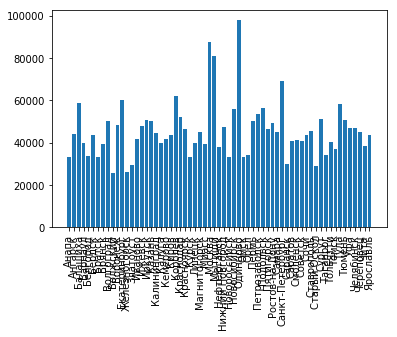

In [0]:
fig,ax=plt.subplots()
plt.bar((city_sals.index),[city_sals[i] for i in city_sals.index])
k=ax.set_xticklabels(city_sals.index, rotation='vertical')
# plt.xlim(0,100)

загрузим данные из интернета и попробуем скореллировать то что получилось с ними, так же добавим признак реиона, которыйнам пригодится в дальнейшем

In [0]:
data_city=pd.read_csv('./city.csv',encoding='cp1251',sep=",")
data_reg_sal=pd.read_csv('./Медианная_зарплата.csv')
region=pd.read_csv('./region.csv',encoding='cp1251',sep=",")
selary=[]
a=[]
for i in task1.CITY:
  selary.append(data_reg_sal[data_reg_sal.Адыгея==region[region.region_id==data_city[data_city.name==i].region_id.iloc[0]].name.iloc[0]].iloc[0,2])
  a.append(region[region.region_id==data_city[data_city.name==i].region_id.iloc[0]].name.iloc[0])

task1['region']=a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [0]:
np.dot(selary,task1.new_City_feature)/(np.linalg.norm(selary)*np.linalg.norm(task1.new_City_feature))


0.9912212014884904

как видно кореляция достаточно высокая поэтому можно считать что данные соответствую действительности

сгруппируем данные и оценим положительность региона согласно дефолтной переменной(т.е. возвращают ли нам деньги из данного региона или нет)

In [0]:
# task1.marital_status
region_groups = task1.groupby("region")
region_reliability = region_groups['target'].mean()
a = []
for i in task1.region.values:
  a.append(region_reliability[i])

a1=[np.where(np.unique(a)==i)[0][0]for i in a]
task1['region_reliability'] = a1
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


проверим, получает ли человек больше средней зарплаты или нет?

In [0]:
# task1.marital_status
a = []
for i in range(task1.shape[0]):
  a.append(int(task1.customer_month_salary.iloc[i]-task1.new_City_feature.iloc[i]>0))

task1['good_boooy'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


посмотрим на распределение категориальных признаков

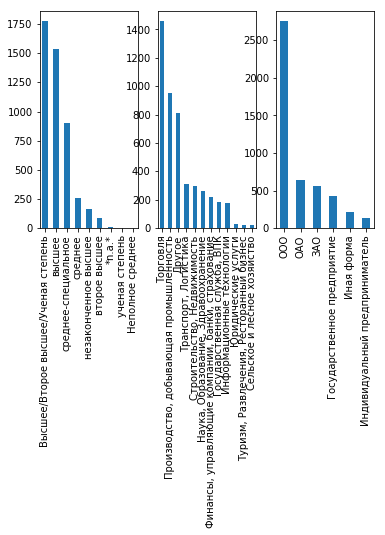

In [0]:
plt.subplot(131)
task1.EDUCATION.value_counts().plot(kind='bar')
plt.subplot(132)
task1.sphere.value_counts().plot(kind='bar')
plt.subplot(133)
task1.form.value_counts().plot(kind='bar')
plt.show()


как результат оно вовсе не равномерное, поэтому попробуем их объеденить и посмотреть что выйдет

посмотрим на возможность доверять людям из разных сфер деятельности с разным образованием и запишем данный признак в виде процентного соотношения

In [0]:
def counts_of_elements(i):
    return task1[(task1['form']==task1['form'].iloc[i])&
          (task1["sphere"]==task1['sphere'].iloc[i])&
          (task1["EDUCATION"]==task1['EDUCATION'].iloc[i])].shape[0]

# task1.marital_status
SEF_groups = task1.groupby(["sphere","EDUCATION","form"])
SEF_reliability = SEF_groups['target'].mean()
a = []
for i in range(task1.shape[0]):
  if counts_of_elements(i)>50:
    a.append(SEF_reliability[task1['sphere'].iloc[i]][task1['EDUCATION'].iloc[i]][
        task1['form'].iloc[i]
    ])
  else:
    a.append(SEF_reliability[task1['sphere'].iloc[i]][task1['EDUCATION'].iloc[i]][
        task1['form'].iloc[i]
    ]*.1)

# a1=[np.where(np.unique(a)==i)[0][0]for i in a]
task1['SEF_reliability'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


построим признак зависимости возврата денег от их матереального положения и гендерного признака одновременно

In [0]:
# task1.marital_status
mG_groups = task1.groupby(["marital_status",'GENDER'])
mG_reliable = mG_groups['target'].mean()
a = []
for i in range(task1.shape[0]):
  if task1[(task1['marital_status']==task1.marital_status.iloc[i])&(task1.GENDER==task1.GENDER.iloc[i])].shape[0]>50:
    a.append(mG_reliable[task1.marital_status.iloc[i]][task1.GENDER.iloc[i]])
  else:
    a.append(mG_reliable[task1.marital_status.iloc[i]][task1.GENDER.iloc[i]]*.1)

a1=[np.where(np.unique(a)==i)[0][0]for i in a]
task1['new_mG_feature'] = a1
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Создадим признак который показывает сколько объект должен будет отдать

In [0]:
a = []
for i in range(task1.shape[0]):
  if task1.sum_credit_current.iloc[i]!=0:
    a.append(float(task1.term_credit_current.iloc[i]/task1.sum_credit_current.iloc[i]))


task1['ratio_sum_term'] = a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [0]:
a = []
for i in range(task1.shape[0]):
  if task1.sum_credit_current.iloc[i]!=0:
    a.append(float(task1.term_credit_current.iloc[i]/task1.sum_credit_current.iloc[i]))


task1['ratio_term_sum'] = a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


создадим признак соотношения запрашиваемой суммы к заработной плате

In [0]:
# task1.form
a = []
for i in range(task1.shape[0]):
  if (task1.customer_month_salary.iloc[i])!=0:
    a.append(task1.sum_credit_current.iloc[i]/task1.customer_month_salary.iloc[i])
  else:
    a.append(0)


task1['ratio_sum_sal'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


создадим признак который нам покажет меньше ли ежемесечная сумма  зароботка объекта

In [0]:
a = []
for i in range(task1.shape[0]):
    a.append(int(task1.customer_month_salary.iloc[i]>2*task1.ratio_sum_term.iloc[i]))

task1['live_feature'] = a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


проранжируем объекты по платёжеспособности

In [0]:
# task1.marital_status

a1=[np.where((np.unique(list(task1.mean_age_salary)))==i)[0][0]for i in task1.mean_age_salary]
task1['new_age_rangir_sal'] = a1
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


добавим признак проверки возраста на возвращение займов

In [0]:
age_groups = task1.groupby(['age'])
age_reliability = age_groups['target'].mean()
a = []
for i in task1.age.values:
  if task1[task1.age.values==i].shape[0]>50:
    a.append(age_reliability[i])
  else:
    a.append(age_reliability[i]*0.1)

a1=[np.where(np.unique(a)==i)[0][0]for i in a]
task1['age_reliability'] = a1
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

Также посмотрим на признак того как от длительности выплат кредита объекты его возвращают

In [0]:
term_groups = task1.groupby(['term_credit_current'])
term_reliability = term_groups['target'].mean()
a = []
for i in task1.term_credit_current.values:
  if task1[task1.term_credit_current.values==i].shape[0]>50:
    a.append(term_reliability[i])
  else:
    a.append(term_reliability[i]*0.1)

a1=[np.where(np.unique(a)==i)[0][0]for i in a]
task1['term_reliability'] = a1
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

ни для кого не секрет что в наш дни нужно учиться и как результат это превратится в зарплату, давайте создадим признак зависимости надежности людей от образования объекта

In [0]:
# task1.form
EDUCATION_groups = task1.groupby("EDUCATION")
EDUCATION_reliability = EDUCATION_groups['target'].mean()
a = []
for i in task1.EDUCATION.values:
  if task1[task1.EDUCATION.values==i].shape[0]>50:
    a.append(EDUCATION_reliability[i])
  else:
    a.append(EDUCATION_reliability[i]*.1)


task1['EDUCATION_reliability'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

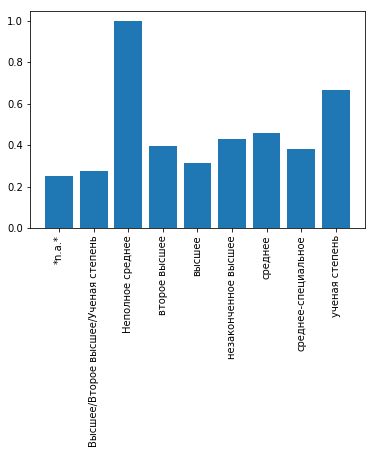

In [0]:
fig,ax=plt.subplots()
plt.bar((EDUCATION_reliability.index),[EDUCATION_reliability[i] for i in EDUCATION_reliability.index])
k=ax.set_xticklabels(EDUCATION_reliability.index, rotation='vertical')
# plt.xlim(0,100)

## Признаки которые не заработали (Данные клетки не юзать!:))

Создадим признак связанный с типом фирмы где работает пользователь и сколько он там зарабатывает

In [0]:
# task1.form
form_groups = task1.groupby("form")
form_sals = form_groups['customer_month_salary'].mean()
a = []
for i in task1.form.values:
  a.append(form_sals[i])

task1['new_form_feature'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

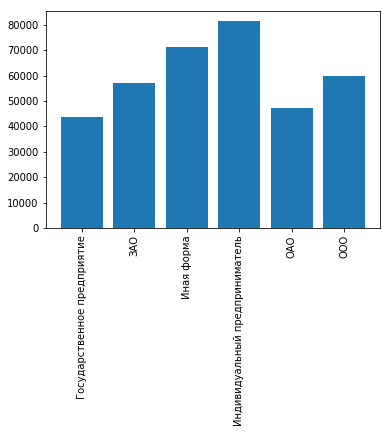

In [0]:
fig,ax=plt.subplots()
plt.bar((form_sals.index),[form_sals[i] for i in form_sals.index])
k=ax.set_xticklabels(form_sals.index, rotation='vertical')
# plt.xlim(0,100)

попробуем связать заработную плату  со сферой деятельности где работает данный объект

In [0]:
# task1.form
sphere_groups = task1.groupby("sphere")
sphere_sals = sphere_groups['customer_month_salary'].mean()
a = []
for i in task1.sphere.values:
  a.append(sphere_sals[i])

task1['new_sphere_feature'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

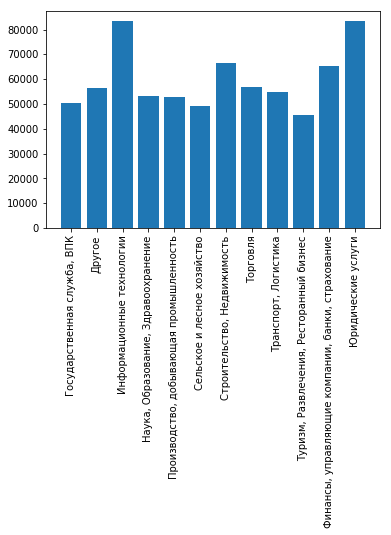

In [0]:
fig,ax=plt.subplots()
plt.bar((sphere_sals.index),[sphere_sals[i] for i in sphere_sals.index])
k=ax.set_xticklabels(sphere_sals.index, rotation='vertical')
# plt.xlim(0,100)

посмотрим на тип занимаемой объектом должности так же при помощи зароботной платы

In [0]:
# task1.form
type_groups = task1.groupby("type")
type_sals = type_groups['customer_month_salary'].mean()
a = []
for i in task1.type.values:
  a.append(type_sals[i])

task1['new_type_feature'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

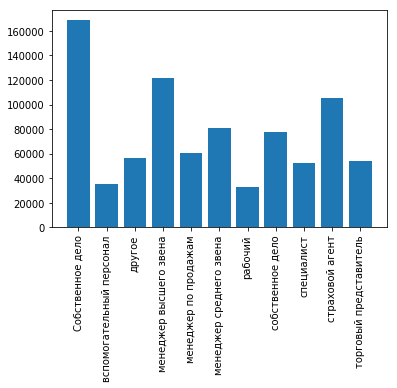

In [0]:
fig,ax=plt.subplots()
plt.bar((type_sals.index),[type_sals[i] for i in type_sals.index])
k=ax.set_xticklabels(type_sals.index, rotation='vertical')
# plt.xlim(0,100)

Я конечно не сексист:) но тоже интересно посмотреть на результаты модели(возвращающая способность и половой признак)

In [0]:
# task1.form
GENDER_groups = task1.groupby("GENDER")
GENDER_reliability = GENDER_groups['target'].mean()
a = []
for i in task1.GENDER.values:
  if task1[task1.GENDER.values==i].shape[0]>50:
    a.append(GENDER_reliability[i])
  else:
    a.append(GENDER_reliability[i]*.1)


task1['GENDER_reliability'] = a
# task1['customer_month_salary'].fillna(task1['mean_age_salary'],inplace=True)

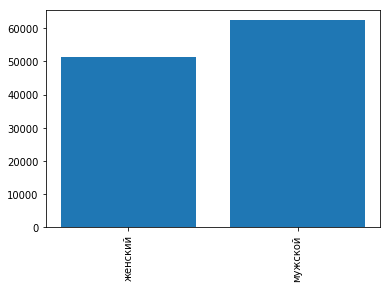

In [0]:
fig,ax=plt.subplots()
plt.bar((GENDER_sals.index),[GENDER_sals[i] for i in GENDER_sals.index])
k=ax.set_xticklabels(GENDER_sals.index, rotation='vertical')
# plt.xlim(0,100)

Таким образом мы поменяли все категориальные признаки и добавили новые

посмотрим на корелляцию признаков

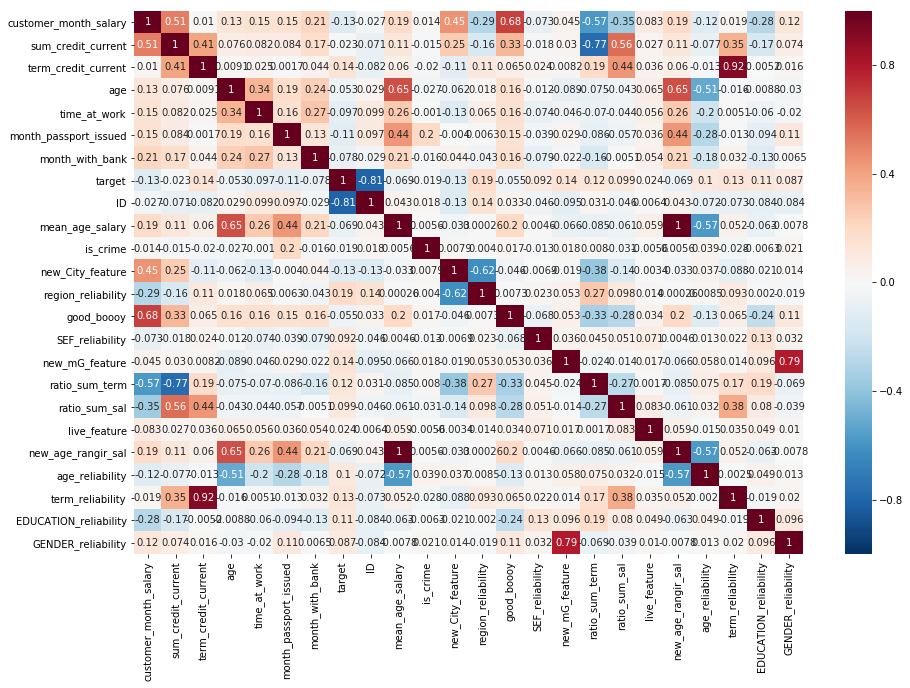

In [0]:
R=task1.corr(method='spearman')
plt.figure(figsize=(15,10))
sns.heatmap(R,vmin=-1,vmax=1,cmap='RdBu_r',annot=True)
plt.show()

заметим что все созданные фичи  кореллируют с таргетом, что должно сыграть нам на руку

##Последняя часть предобработки

In [0]:
label_encoder = preprocessing.LabelEncoder()
label_encoder

LabelEncoder()

In [0]:
X_train1, X_test1 = train_test_split(task1,test_size=0.28,random_state=42)

посмотрим на распределение классов в выборке

In [0]:
X_train1.target.value_counts()/X_train1.shape[0]

0    0.680152
1    0.319848
Name: target, dtype: float64

Видно, что классы не сбалансированы. При использовании модели типа ...Tree, необходимо провести resampling данных.

In [0]:
def resampling(df):
    count_class = df['target'].value_counts()

    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    
    df_class_1_over = df_class_1.sample(count_class[0], replace=True)
    df_oversample = pd.concat([df_class_0, df_class_1_over], axis=0)
    
    return df_oversample


In [0]:
X_train1=resampling(X_train1)

In [0]:
X_train1.target.value_counts()/X_train1.shape[0]

1    0.5
0    0.5
Name: target, dtype: float64

In [0]:
X_train1.columns

Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'age', 'marital_status',
       'time_at_work', 'GENDER', 'month_passport_issued', 'month_with_bank',
       'CITY', 'target', 'ID', 'mean_age_salary', 'is_crime',
       'new_City_feature', 'region', 'region_reliability', 'good_boooy',
       'SEF_reliability', 'new_mG_feature', 'ratio_sum_term', 'ratio_term_sum',
       'ratio_sum_sal', 'live_feature', 'new_age_rangir_sal',
       'age_reliability', 'term_reliability', 'EDUCATION_reliability'],
      dtype='object')

In [0]:
columns=['CITY', 'target', 'ID', 'mean_age_salary','age','marital_status', 'GENDER', 'is_crime','form','EDUCATION','type','sphere',
       'new_City_feature', 'region','customer_month_salary']
y_train,X_train=X_train1.target,X_train1.drop(columns=columns)
y_test,X_test=X_test1.target,X_test1.drop(columns=columns)

In [0]:
for i in range(X_train.shape[1]):
    if type(X_train.iloc[0,i])==str:
        X_train.iloc[:, i] = label_encoder.fit_transform(X_train.iloc[:, i])
X_train.head()
for i in range(X_test.shape[1]):
    if type(X_test.iloc[0,i])==str:
        X_test.iloc[:, i] = label_encoder.fit_transform(X_test.iloc[:, i])
X_test.head()

,sum_credit_current,term_credit_current,time_at_work,month_passport_issued,month_with_bank,region_reliability,good_boooy,SEF_reliability,new_mG_feature,ratio_sum_term,ratio_term_sum,ratio_sum_sal,live_feature,new_age_rangir_sal,age_reliability,term_reliability,EDUCATION_reliability
2340,650000,60,151.0,13,45.000000,3,0,0.355000,5,0.000092,0.000092,10.262595,1,8,8,26,0.382483
361,750000,60,4.0,140,23.000000,3,1,0.033333,9,0.000080,0.000080,2.500000,1,38,9,26,0.397590
1419,450000,60,13.0,86,43.957663,34,1,0.028571,5,0.000133,0.000133,12.784650,1,10,29,26,0.316234
1738,750000,60,187.0,171,109.000000,3,0,0.016129,4,0.000080,0.000080,10.714286,1,38,9,26,0.274620
3968,141000,60,23.0,113,5.000000,30,0,0.364486,8,0.000426,0.000426,6.146367,1,9,27,26,0.382483


#Обучение

##LogisticRegression

In [0]:
logistik=LogisticRegression(solver='liblinear', max_iter=2000,penalty='l1',class_weight ='balanced',C=2)


In [0]:
logistic=logistik.fit(X_train,y_train)

In [0]:
y_pred=logistic.predict(X_test)

In [0]:
print("LogisticRegression roc_auc_score = {:.3f}".format(roc_auc_score(y_test, 
                                                           y_pred)))

LogisticRegression roc_auc_score = 0.619


Даже очень не плохо для линейной модели

## XGBoosting

In [0]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=500,booster='gbtree',objective="binary:logistic",n_jobs=10,min_child_weight=1,
                                                               max_delta_step=1,subsample=1,colsample_bytree=1,colsample_bylevel=.5, reg_alpha=1,reg_lambda=1.7,max_depth=4,
                                                               base_score=.481,scale_pos_weight=1,random_state=0)

In [0]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.481, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=10, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=1, reg_lambda=1.7, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [0]:
y_pred=xgb.predict(X_test)

In [0]:
print("XGBClassifier roc_auc_score = {:.3f}".format(roc_auc_score(y_test, 
                                                           y_pred)))
print(X_test.columns)

XGBClassifier roc_auc_score = 0.639
Index(['sum_credit_current', 'term_credit_current', 'time_at_work',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'new_mG_feature', 'ratio_sum_term',
       'ratio_term_sum', 'ratio_sum_sal', 'live_feature', 'new_age_rangir_sal',
       'age_reliability', 'term_reliability', 'EDUCATION_reliability'],
      dtype='object')


###Далее я привиду всю историю моих проб и ошибок по добавлению фичей

age->salary_age .607
CITY-new->City .611
sal/sum ,0.593



sal/sum(deleted) term/sum(add).622
параметры:'target', 'ID', 'age','CITY',
       'new_marital_feature', 'new_form_feature', 'new_EDUCATION_feature',
       'new_sphere_feature', 'new_type_feature', 'new_GENDER_feature',
       'ratio_sum_sal'


GENDER->new_gender 0.611


XGBClassifier roc_auc_score = 0.611
Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'marital_status', 'time_at_work',
       'GENDER', 'month_passport_issued', 'month_with_bank',
       'region_reliability', 'ratio_sum_sal'],
      dtype='object')
      
XGBClassifier roc_auc_score = 0.612
Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'marital_status', 'time_at_work',
       'GENDER', 'month_passport_issued', 'month_with_bank',
       'region_reliability', 'ratio_sum_sal', 'new_age_rangir_sal'],
      dtype='object')
      
      
XGBClassifier roc_auc_score = 0.617
Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'marital_status', 'time_at_work',
       'GENDER', 'month_passport_issued', 'month_with_bank',
       'region_reliability', 'ratio_sum_sal', 'new_age_rangir_sal',
       'age_reliability'],
      dtype='object')
      
      
XGBClassifier roc_auc_score = 0.620
Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'marital_status', 'time_at_work',
       'GENDER', 'month_passport_issued', 'month_with_bank',
       'region_reliability', 'SEF_reliability', 'ratio_sum_sal',
       'new_age_rangir_sal', 'age_reliability'],
      dtype='object')
      
XGBClassifier roc_auc_score = 0.621
Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'marital_status', 'time_at_work', 'GENDER',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'ratio_sum_sal', 'new_age_rangir_sal',
       'age_reliability'],
      dtype='object')
      
XGBClassifier roc_auc_score = 0.626
Index(['sum_credit_current', 'term_credit_current', 'form', 'time_at_work',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'ratio_sum_sal', 'live_feature',
       'new_age_rangir_sal', 'age_reliability'],
      dtype='object')
      
      XGBClassifier roc_auc_score = 0.633
Index(['sum_credit_current', 'term_credit_current', 'form', 'time_at_work',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'ratio_sum_sal', 'live_feature',
       'new_age_rangir_sal', 'age_reliability', 'term_reliability'],
      dtype='object')
      
      XGBClassifier roc_auc_score = 0.642
Index(['sum_credit_current', 'term_credit_current', 'form', 'time_at_work',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'ratio_sum_sal', 'live_feature',
       'new_age_rangir_sal', 'age_reliability', 'term_reliability',
       'EDUCATION_reliability'],
      dtype='object')

##LGBMClassifier

In [0]:
lgbm = LGBMClassifier(learning_rate=0.1,n_estimators=500,boosting_type='gbdt',objective="binary",n_jobs=10,min_child_weight=1,max_delta_step=1,
                                                                subsample=1,colsample_bytree=1,colsample_bylevel=.5, reg_alpha=1,reg_lambda=1.7,max_depth=4,base_score=.491,
                                                                scale_pos_weight=1,random_state=0)

In [0]:
lgbm.fit(X_train, y_train)

LGBMClassifier(base_score=0.491, boosting_type='gbdt', class_weight=None,
        colsample_bylevel=0.5, colsample_bytree=1, importance_type='split',
        learning_rate=0.1, max_delta_step=1, max_depth=4,
        min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
        n_estimators=500, n_jobs=10, num_leaves=31, objective='binary',
        random_state=0, reg_alpha=1, reg_lambda=1.7, scale_pos_weight=1,
        silent=True, subsample=1, subsample_for_bin=200000,
        subsample_freq=0)

In [0]:
y_pred=lgbm.predict(X_test)

In [0]:
print("LGBMClassifier roc_auc_score = {:.3f}".format(roc_auc_score(y_test, 
                                                           y_pred)))
print(X_test.columns)

LGBMClassifier roc_auc_score = 0.626
Index(['sum_credit_current', 'term_credit_current', 'time_at_work',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'new_mG_feature', 'ratio_sum_term',
       'ratio_term_sum', 'ratio_sum_sal', 'live_feature', 'new_age_rangir_sal',
       'age_reliability', 'term_reliability', 'EDUCATION_reliability'],
      dtype='object')


LGBMClassifier roc_auc_score = 0.623
Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'marital_status', 'time_at_work',
       'GENDER', 'month_passport_issued', 'month_with_bank',
       'region_reliability', 'good_boooy', 'SEF_reliability', 'ratio_sum_sal',
       'new_age_rangir_sal', 'age_reliability'],
      dtype='object')
      
      
LGBMClassifier roc_auc_score = 0.624
Index(['sum_credit_current', 'term_credit_current', 'form', 'time_at_work',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'ratio_sum_sal', 'live_feature',
       'new_age_rangir_sal', 'age_reliability', 'term_reliability',
       'EDUCATION_reliability'],)
       
LGBMClassifier roc_auc_score = 0.637
Index(['sum_credit_current', 'term_credit_current', 'form', 'time_at_work',
       'month_passport_issued', 'month_with_bank', 'region_reliability',
       'good_boooy', 'SEF_reliability', 'ratio_sum_sal', 'live_feature',
       'new_age_rangir_sal', 'age_reliability', 'term_reliability',
       'EDUCATION_reliability'],
      dtype='object')
       

##RandomForestClassifier

In [0]:
RF=RandomForestClassifier(n_estimators=1000,criterion='entropy',n_jobs=10,class_weight='balanced',random_state=50)

In [0]:
RF=RF.fit(X_train,y_train)

In [0]:
y_pred=RF.predict(X_test)

In [0]:
print("RandomForestClassifier roc_auc_score = {:.3f}".format(roc_auc_score(y_test, 
                                                           y_pred)))

RandomForestClassifier roc_auc_score = 0.604


RandomForestClassifier roc_auc_score = 0.579
0.576 0.584 .569

##ExtraTreesClassifier

In [0]:
trees = ExtraTreesClassifier(n_estimators=200,criterion='entropy' ,class_weight='balanced',random_state=50)

In [0]:
tree=trees.fit(X_train, y_train)

In [0]:
y_pred_tree=trees.predict(X_test)

In [0]:
print("ExtraTrees roc_auc_score = {:.3f}".format(roc_auc_score(y_test, 
                                                           y_pred_tree)))

ExtraTrees roc_auc_score = 0.556


##DecisionTreesClassifier

In [0]:
trees = DecisionTreeClassifier(criterion='entropy' ,class_weight='balanced',random_state=50)

In [0]:
trees.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=50,
            splitter='best')

In [0]:
y_pred_tree=trees.predict(X_test)

In [0]:
print("DecisionTree roc_auc_score = {:.3f}".format(roc_auc_score(y_test, 
                                                           y_pred_tree)))

DecisionTree roc_auc_score = 0.567


### ещё немножечко истории что было вообще до создания новых признаков

13 категориальных признаков

логрег 0.504930914144293

RF 0.5474782592205206

LGBM 0.5719847454134422

XGB 0.5816246483620005

поменяли AGE

логрег 0.5157507372229485

RF 0.5491302078041572

LGBM 0.5735693644183562-

XGB 0.579075005038723

ввели города
логрег 0.504930914144293

RF 0.5474782592205206

LGBM 0.5719847454134422

XGB 0.5816246483620005

Index(['customer_month_salary', 'sum_credit_current', 'term_credit_current',
       'form', 'sphere', 'type', 'EDUCATION', 'marital_status', 'time_at_work',
       'GENDER', 'month_passport_issued', 'month_with_bank', 'mean_age_salary',
       'new_City_feature'],
      dtype='object')
      
LogisticRegression= 0.5110444984402519
RandomForestClassifier= 0.5065846509547375
LGBMClassifier= 0.48977282722827675
XGBClassifier= 0.48977325797857957

marital status->new_marital_feature

LogisticRegression= 0.510624948931434
RandomForestClassifier= 0.5037454403802901
LGBMClassifier= 0.4894885068310698
XGBClassifier= 0.4970984816462044

form->new_for_feature

LogisticRegression= 0.5064507614297047
RandomForestClassifier= 0.5090490733972689
LGBMClassifier= 0.4957247100287706
XGBClassifier= 0.4971878809861865

EDUCATION->new_EDUCATION_feature

LogisticRegression= 0.5142103202986342
RandomForestClassifier= 0.5065618344326094
LGBMClassifier= 0.4935920126104686
XGBClassifier= 0.48994390933828935

sphere->new_sphere_feature

LogisticRegression= 0.507625360882679
RandomForestClassifier= 0.5052880402278255
LGBMClassifier= 0.4990065916857236
XGBClassifier= 0.4989113458429853

type->new_type_feature

LogisticRegression= 0.5230481484682468
RandomForestClassifier= 0.5057822483808542
LGBMClassifier= 0.4968544115277066
XGBClassifier= 0.4918847520988602

GENDER->new_GENDER_feature

LogisticRegression= 0.5440467321755831
RandomForestClassifier= 0.5081343895098456
LGBMClassifier= 0.4968544115277066
XGBClassifier= 0.49187925995567683